# Import

In [19]:
import glob
import os
import sys
import random
import time
import numpy as np
import cv2
import math
import datetime
from scipy.spatial import cKDTree as kdtree
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.applications.xception import Xception
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.models import model_from_json
import pandas as pd
from plotnine import *
from jupyterplot import ProgressPlot
#from keras.callbacks import TensorBoard

import tensorflow as tf
import keras.backend.tensorflow_backend as backend
from threading import Thread
from tqdm import tqdm_notebook as tqdm

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass
import carla
print('IMPORT DONE')

IMPORT DONE


# Car Environment [Action/Reward here]

In [20]:
class CarEnv:
    global town
    #BRAKE_AMT = 1.0
    actor_list = []
    collision_hist = []
    pt_cloud = []
    pt_cloud_filtered = []
    
    def __init__(self):
        self.client = carla.Client('localhost', 2000)
        self.client.set_timeout(2.0)
        world = self.client.load_world(town)
        self.world = self.client.get_world()
        blueprint_library = self.world.get_blueprint_library()
        self.model_3 = blueprint_library.filter('model3')[0]
        self.truck_2 = blueprint_library.filter('carlamotors')[0]
        self.place=0
        
        spectator = self.world.get_spectator()
        spectator.set_transform(carla.Transform(carla.Location(249,-120,3), carla.Rotation(yaw=-90)))
        
        #spawn a vehicle
        blueprint_library = self.world.get_blueprint_library()
        self.Isetta = blueprint_library.filter('Isetta')[0]
        
        
    def Black_screen(self):
        settings = self.world.get_settings()
        settings.no_rendering_mode = True
        self.world.apply_settings(settings)
    
    def set_location(self,x,y):
        
        self.lo_x,self.lo_y=x,y
        self.place=x,y
        
    def get_distance(self):
        l=self.vehicle.get_location()
        current_location=[l.x,l.y]
        dist,indice=kd_tree_map.query(current_location,1)
        return dist
    def get_location(self):
        l=self.vehicle.get_location()
        current_location=[l.x,l.y]
        return current_location
                     
    def reset(self):
        self.collision_hist = []
        self.actor_list = []
        self.pt_cloud = []
        self.pt_cloud_filtered = []
        
        ##print('Location: ',str(place))
        #transform = carla.Transform(carla.Location(-120,place,3),carla.Rotation(0,-90,0))
        if self.place == 0:
            transform = carla.Transform(carla.Location(249,-130,0.1),carla.Rotation(0,-90,0)) 
        else :
            transform = carla.Transform(carla.Location(self.lo_x,self.lo_y),carla.Rotation(0,-90,0))  
            
        self.flag = 0
        self.vehicle = self.world.spawn_actor(self.Isetta, transform)
        self.flag = 1
        
        self.actor_list.append(self.vehicle)
     

        self.lidar_sensor = self.world.get_blueprint_library().find('sensor.lidar.ray_cast')
        self.lidar_sensor.set_attribute('points_per_second', '100000')
        self.lidar_sensor.set_attribute('channels', '32')
        self.lidar_sensor.set_attribute('range', '10000')
        self.lidar_sensor.set_attribute('upper_fov', '10')
        self.lidar_sensor.set_attribute('lower_fov', '-10')
        self.lidar_sensor.set_attribute('rotation_frequency', '60')
        
        transform = carla.Transform(carla.Location(x=0, z=1.9))
        time.sleep(0.01)

        self.sensor = self.world.spawn_actor(self.lidar_sensor, transform, attach_to=self.vehicle)
     
        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_lidar(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0))
        self.episode_start = time.time()
   
        time.sleep(0.4) # sleep to get things started and to not detect a collision when the car spawns/falls from sky.
        
        transform2 = carla.Transform(carla.Location(x=2.5, z=0.7))
        colsensor = self.world.get_blueprint_library().find('sensor.other.collision')
        self.colsensor = self.world.spawn_actor(colsensor, transform2, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))

        while self.distance_to_obstacle_f is None:
            time.sleep(0.01)

        self.episode_start = time.time()
        
        self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0))
        ref_map=self.get_distance()
        ##SENSOR LIDAR
        xx = self.distance_to_obstacle_f
        yy = self.distance_to_obstacle_r
        zz = self.distance_to_obstacle_l
        state_=np.array([xx,yy,zz,ref_map])
        
        return state_

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_lidar(self, raw):
        points = np.frombuffer(raw.raw_data, dtype=np.dtype('f4'))
        points = np.reshape(points, (int(points.shape[0] / 3), 3))*np.array([1,-1,-1])
        
        lidar_f = lidar_line(points,90,2)
        lidar_r = lidar_line(points,45,2)
        lidar_l = lidar_line(points,135,2)

        if len(lidar_f) == 0:
            pass
        else:
            self.distance_to_obstacle_f = min(lidar_f[:,1])-2.247148275375366
        
        if len(lidar_r) == 0:
            pass
        else:
            self.distance_to_obstacle_r = np.sqrt(min(lidar_r[:,0]**2 + lidar_r[:,1]**2))
        
        if len(lidar_l) == 0:
            pass
        else:
            self.distance_to_obstacle_l = np.sqrt(min(lidar_l[:,0]**2 + lidar_l[:,1]**2))
    

    def step(self, action):
        global sleepy,steer_
        
        ref_map=self.get_distance()
        
        set_reward=3-ref_map
        
        if action == 0:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0))
            time.sleep(sleepy)
            steer_+=0
            reward = set_reward
        elif action == 1:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.1))
            time.sleep(sleepy)
            steer_+=0.1
            reward = set_reward
        elif action == 2:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = -0.1))
            time.sleep(sleepy)
            steer_+=-0.1
            reward = set_reward
        elif action == 3:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.3))
            time.sleep(sleepy)
            steer_+=0.3
            reward = set_reward
        elif action == 4:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = -0.3))
            time.sleep(sleepy)
            steer_+=-0.3
            reward = set_reward
 

        
        if len(self.collision_hist) != 0:
            done = True
        else :
            done=False
            
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            
        xx = self.distance_to_obstacle_f
        yy = self.distance_to_obstacle_r
        zz = self.distance_to_obstacle_l
        state_=np.array([xx,yy,zz,ref_map])
            
        return state_, reward, done, None
    
    def test_step(self,steer,sleepy):
        ref_map=self.get_distance()
        self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = steer))
        time.sleep(sleepy)
        reward = 1
        
        if len(self.collision_hist) != 0:
            done = True
        else :
            done=False
        
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            
        xx = self.distance_to_obstacle_f
        yy = self.distance_to_obstacle_r
        zz = self.distance_to_obstacle_l
        state_=np.array([xx,yy,zz,ref_map])
            
        return state_, reward, done, None
        

# Optional Function

In [21]:
def open_carla(require):
    try:
        if require == 'fast':
            os.popen('C:\\Users\\nbhah\\Desktop\\Carla\\CarlaUE4\\Binaries\\Win64\\CarlaUE4.exe -benchmark  -fps=10 -quality-level=Low')
        else:
            os.popen('C:\\Users\\nbhah\\Desktop\\Carla\\CarlaUE4\\Binaries\\Win64\\CarlaUE4.exe')
    except Exception as err:
        print(err)
    print('opening Carla')
    
def close_carla():
    try:
        os.system('TASKKILL /F /IM CarlaUE4.exe')
    except Exception as err:
        print(err)
    time.sleep(0.5)
    
def carla_is_running():
    import psutil    
    if "CarlaUE4.exe" in (p.name() for p in psutil.process_iter()):
        return True
    
def xxx():
    env.world.wait_for_tick()
    for x in list(env.world.get_actors()):
        if x.type_id == 'vehicle.tesla.model3' or x.type_id == 'sensor.lidar.ray_cast' or x.type_id == 'sensor.other.collision':
            x.destroy()
            
def lidar_line(points,degree,width):
    angle = degree*(2*np.pi)/360
    points_l = points
    points_l = points_l[np.logical_and(points_l[:,2] > -1.75, points_l[:,2] < 1000)] #z
    points_l = points_l[np.logical_and(np.tan(angle)*points_l[:,0]+width*np.sqrt(1+np.tan(angle)**2)>=points_l[:,1], np.tan(angle)*points_l[:,0]-width*np.sqrt(1+np.tan(angle)**2)<=points_l[:,1])] #y
    if 180>degree >0:
        points_l = points_l[np.logical_and(points_l[:,1]>0, points_l[:,1]<1000)] #y>0
    if 180<degree<360:
        points_l = points_l[np.logical_and(points_l[:,1]<0, points_l[:,1] > -1000)] #x
    if degree == 0 or degree == 360:
        points_l = points_l[np.logical_and(points_l[:,0]>0,points_l[:,0] <1000 )] #x
    if degree == 180:
        points_l = points_l[np.logical_and(points_l[:,0] >-1000 , points_l[:,0]<0 )]
    return  points_l

map=pd.read_csv('DATA\map_straight.csv')
kd_tree_map=kdtree(map.values)

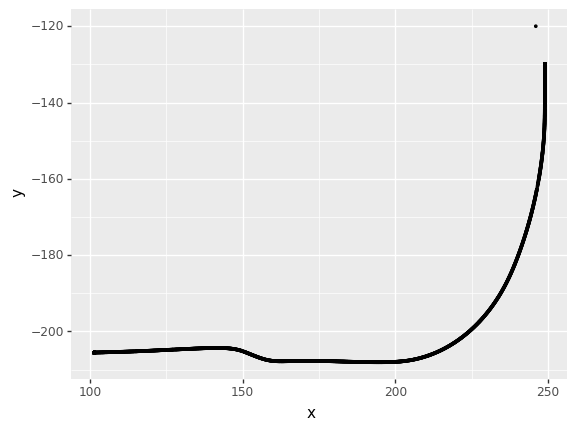

<ggplot: (163516527771)>

In [33]:
ggplot(map)+\
geom_point(aes(x='x',y='y'),size=0.5)

# DQN Algorithm

In [23]:
class DQNAgent:
    
    def __init__(self,state_size,action_size):
        self.state_size=state_size
        self.action_size=action_size
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        self.target_update_counter = 0
        #self.graph = tf.get_default_graph()

        self.terminate = False
        self.last_logged_episode = 0
        self.training_initialized = False
    
    def get_weight(self):
        
        w = self.model.get_weights()        
        return w
    
    def predict(self,state):
        
        predict = self.model.predict(state.reshape((1, self.state_size)))
        return predict
    
    def save_model(self,name):
        model_json = self.model.to_json()
        with open("{}.json".format(name), "w") as json_file:
            json_file.write(model_json)
        self.model.save_weights("{}.h5".format(name))
        print("Saved model to disk")     
        

    def create_model(self):
        
        model = Sequential()
        model.add(Dense(4, input_dim=self.state_size, activation='relu'))
        model.add(Dense(32, input_dim=4, activation='relu')) 
        model.add(Dense(self.action_size, activation='sigmoid'))            # output nodes = #action
        model.compile(loss='mse', optimizer=Adam(lr=0.01))
        return model

    def update_replay_memory(self, transition):
        # transition = (current_state, action, reward, new_state, done)
        self.replay_memory.append(transition)

    def train(self):
        global Loss
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            self.terminate=True
            Loss.append(0)
            return

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        
        current_states = np.array([transition[0] for transition in minibatch])
        
        #with self.graph.as_default():
        current_qs_list = self.model.predict(current_states, PREDICTION_BATCH_SIZE)

        new_current_states = np.array([transition[3] for transition in minibatch])
        
        #with self.graph.as_default():
        future_qs_list = self.target_model.predict(new_current_states, PREDICTION_BATCH_SIZE)

        X = []
        y = []

        for index, (current_state, action, reward, new_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            current_qs = current_qs_list[index]
            current_qs[action] = new_q
            
            X.append(current_state)
            y.append(current_qs)


        history=self.model.fit(np.array(X), np.array(y), batch_size=TRAINING_BATCH_SIZE, verbose=0, shuffle=False)
        history
        Loss.append(history.history['loss'][0])
        self.target_model.set_weights(self.model.get_weights())

    def get_qs(self, state):
        return self.model.predict(state.reshape((1, self.state_size)))[0]
        
    def train_in_loop(self):
        X = np.random.uniform(size=(1, self.state_size)).astype(np.float32)
        y = np.random.uniform(size=(1, self.action_size)).astype(np.float32)
        
        self.model.fit(X,y, verbose=False, batch_size=1)

        self.training_initialized = True
        print('Start Train')
        while True:
            if self.terminate:
                return
            self.train()
            time.sleep(0.01)

In [24]:
class DQNAgent_load_model:
    
    def __init__(self,state_size,action_size,model):
        self.state_size=state_size
        self.action_size=action_size
        self.model = self.loaded_model(model)
        self.target_model = self.loaded_model(model)
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        self.target_update_counter = 0
        #self.graph = tf.get_default_graph()

        self.terminate = False
        self.last_logged_episode = 0
        self.training_initialized = False
        
    def loaded_model(self,model):
        
        model.compile(loss='mse', optimizer=Adam(lr=0.01))
        return model
    
    def get_weight(self):
        
        w = self.model.get_weights()        
        return w
    
    def predict(self,state):
        
        predict = self.model.predict(state.reshape((1, self.state_size)))
        return predict
    
    def save_model(self,name):
        model_json = self.model.to_json()
        with open("{}.json".format(name), "w") as json_file:
            json_file.write(model_json)
        self.model.save_weights("{}.h5".format(name))
        print("Saved model to disk")     

    def update_replay_memory(self, transition):
        # transition = (current_state, action, reward, new_state, done)
        self.replay_memory.append(transition)

    def train(self):
        global Loss
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            self.terminate=True
            Loss.append(0)
            return

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        
        current_states = np.array([transition[0] for transition in minibatch])
        
        
        #with self.graph.as_default():
        current_qs_list = self.model.predict(current_states, PREDICTION_BATCH_SIZE)

        new_current_states = np.array([transition[3] for transition in minibatch])
        
        #with self.graph.as_default():
        future_qs_list = self.target_model.predict(new_current_states, PREDICTION_BATCH_SIZE)

        X = []
        y = []

        for index, (current_state, action, reward, new_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            current_qs = current_qs_list[index]
            current_qs[action] = new_q
            
            X.append(current_state)
            y.append(current_qs)


        history=self.model.fit(np.array(X), np.array(y), batch_size=TRAINING_BATCH_SIZE, verbose=0, shuffle=False)
        history
        Loss.append(history.history['loss'][0])
        self.target_model.set_weights(self.model.get_weights())

    def get_qs(self, state):
        return self.model.predict(state.reshape((1, self.state_size)))[0]
        
    def train_in_loop(self):
        X = np.random.uniform(size=(1, self.state_size)).astype(np.float32)
        y = np.random.uniform(size=(1, self.action_size)).astype(np.float32)
        
        self.model.fit(X,y, verbose=False, batch_size=1)

        self.training_initialized = True
        print('Start Train')
        while True:
            if self.terminate:
                return
            self.train()
            time.sleep(0.01)

# Input

In [25]:
SECONDS_PER_EPISODE = 100
REPLAY_MEMORY_SIZE = 5_000
MIN_REPLAY_MEMORY_SIZE = 32
MINIBATCH_SIZE = 32
PREDICTION_BATCH_SIZE = 1
TRAINING_BATCH_SIZE = MINIBATCH_SIZE // 4
UPDATE_TARGET_EVERY = 5


MEMORY_FRACTION = 0.4
MIN_REWARD = -200

EPISODES = 32000

DISCOUNT = 0.99
epsilon = 1
EPSILON_DECAY = 0.99975 ## 0.9975 99975
MIN_EPSILON = 0.001

AGGREGATE_STATS_EVERY = 10
state_size=4
action_size=5

# NEW model or LOAD model

In [26]:
def load_model(model_name):
    json_file = open('DATA\\{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("DATA\\{}.h5".format(model_name))
    
    print("Loaded model from disk")
    loaded_model.summary()
    
    file_path="DATA\\"
    df=pd.read_csv(file_path+'{}.csv'.format(model_name))
    episode = df.Episode.tail(1).values[0]+1
    epsilon = df.Epsilon.tail(1).values[0]
    print('Episode : {} , Epsilon : {} '.format(episode,epsilon))
    
    return df,episode,epsilon,loaded_model
    

In [27]:
def save_every_5k(name,n):
    file_path="DATA\\"
    df.to_csv(file_path+'{}_{}.csv'.format(name,n))
    agent.save_model(file_path+name+'_'+str(n))

In [28]:
LOAD = False
model_name='backup\Steer_Full_2_040520_2130'
if LOAD == True :
    df_load,load_episode,load_epsilon,loaded_model = load_model(model_name)
    value=['Episode','Reward','avg_reward','Step','Loss','avg_loss','Steer','Explore','PCT_Explore','Epsilon']
    df_load=df_load[value]
    df_load

In [29]:
#df_load.plot.scatter('Episode','avg_reward')

# MAIN

In [31]:
if __name__ == '__main__':
    
    
    if carla_is_running():
        pass
    else:
        close_carla()
        open_carla('not fast')
        time.sleep(17)
    #open_carla('fast')
    FPS=60
    town='town03'
    ep_rewards = []
    ep=[]
    avg=0
    av_loss=0
    avg_loss=[]
    avg_reward=[]
    Step=[]
    Loss=[]
    Explore=[]
    Steer=[]
    Epsilon=[]
    random.seed(1)
    np.random.seed(1)
    steer_amt=0.3
    sleepy=0.3

    #pp = ProgressPlot(x_label="Episode",line_names=['Average_reward'])
    
    if LOAD == True:
    # In case Train from loaded_model
        agent=DQNAgent_load_model(state_size,action_size,loaded_model)
        epsilon=load_epsilon
        nn=0
        for i in df_load.Reward:
            avg=((avg*(nn)+i)/(nn+1))
            #pp.update(float(avg))
            nn+=1
        avg=sum(df_load.Reward)/df_load.shape[0]
        av_loss=sum(df_load.Loss)/df_load.shape[0]
    else :
        
    # Create agent and environment
        agent = DQNAgent(state_size,action_size)
        load_episode=0
    
    env = CarEnv()
    #env.Black_screen()
    xxx()
    
    agent.train_in_loop()
    agent.get_qs(np.ones((1, state_size)))
    
    ## Re_epsilon
    epsilon = 0.1

    # Iterate over episodes
    with tqdm(total=EPISODES-load_episode) as pbar:
        
        for episode in range(EPISODES-load_episode):            
            #try:

            env.collision_hist = []
            episode_reward = 0
            loss=0
            step = 1
            explore=0
            steer_=0

            # Reset environment and get initial state
            current_state = env.reset()

            # Reset flag and start iterating until episode ends
            done = False
            episode_start = time.time()

            # Play for given number of seconds only
            while True:

                # This part stays mostly the same, the change is to query a model for Q values
                rand=np.random.random()
                if rand > epsilon:
                    # Get action from Q table
                    action = np.argmax(agent.get_qs(current_state))
                    #action=loaded_model.predict(state)
                    #a=agent.get_qs(current_state)
                    
                    #a1=a[0]/a.sum()
                    #a2=a[1]/a.sum()            
                    #steer=(-steer_amt*a1)+(steer_amt*a2)
                    #new_state,reward,done,_= env.test_step(steer,sleepy)
                    
                    new_state, reward, done, _ = env.step(action)
                    #steer_+=steer
                    time.sleep(1/FPS)
                    
                else:
                    # Get random action
                    action = np.random.randint(0, action_size)
                    new_state, reward, done, _ = env.step(action)
                    explore+=1
                    
                    #if action==0:
                        #steer_+=steer_amt
                    #else :
                        #steer_-=steer_amt
                    
            
                    # This takes no time, so we add a delay matching 60 FPS (prediction above takes longer)
                    time.sleep(1/FPS)
             
                # Every step we update replay memory
                episode_reward += reward
              
                agent.update_replay_memory((current_state, action, reward, new_state, done))
                current_state = new_state
                step += 1

                if done:
                    break
                    
            # End of episode - destroy agents
            for actor in env.actor_list:
                actor.destroy()
            agent.train()
            
            # Decay epsilon
            if epsilon > MIN_EPSILON:
                epsilon *= EPSILON_DECAY
                epsilon = max(MIN_EPSILON, epsilon)
                
            print('Episode :{}, Step :{}, Epsilon :{} ,Reward :{}, Explore_rate :{}, loss :{} ,Steer :{}'\
                  .format(episode+load_episode,step,epsilon,episode_reward,explore/step,Loss[episode],steer_/step))
            
            ep_rewards.append(episode_reward)
            ep.append(episode+load_episode)
            Step.append(step)
            Explore.append(explore)
            Steer.append(steer_/step)
            Epsilon.append(epsilon)
            avg=((avg*(episode+load_episode)+episode_reward)/(episode+load_episode+1))
            avg_reward.append(avg)
            av_loss=((av_loss*(episode+load_episode)+Loss[episode])/(episode+load_episode+1))
            avg_loss.append(av_loss)
            #pp.update(float(avg))  
            
            if (episode+load_episode) %5000 ==0 :
                df=pd.DataFrame({'Episode':ep,'Reward':ep_rewards,\
                 'avg_reward':avg_reward,'Step':Step,'Loss':Loss[1:],\
                 'avg_loss':avg_loss,\
                'Steer':Steer,'Explore':Explore,'PCT_Explore':np.array(Explore)/np.array(Step)*100\
                ,'Epsilon':Epsilon})
                if LOAD == True:
                    df=pd.concat([df_load,df],ignore_index=True)
                save_every_5k(model_name,episode+load_episode)
            
            
            #pbar.update(1)
    close_carla()
    pp.finalize()
   

Start Train


Episode :0, Step :19, Epsilon :0.09997500000000001 ,Reward :41.80062053921286, Explore_rate :0.21052631578947367, loss :0 ,Steer :0.19999999999999998
Saved model to disk
Episode :1, Step :20, Epsilon :0.09995000625000001 ,Reward :41.88063263625531, Explore_rate :0.1, loss :0 ,Steer :0.185
Episode :2, Step :21, Epsilon :0.09992501874843751 ,Reward :42.968659898606134, Explore_rate :0.047619047619047616, loss :1.3451444804668427 ,Steer :0.18095238095238098
Episode :3, Step :20, Epsilon :0.0999000374937504 ,Reward :40.70402518059964, Explore_rate :0.0, loss :1.2347746193408966 ,Steer :0.205



KeyboardInterrupt: 

# Graph

In [ ]:
df=pd.DataFrame({'Episode':ep,'Reward':ep_rewards,\
                 'avg_reward':avg_reward,'Step':Step,'Loss':Loss[1:],\
                 'avg_loss':avg_loss,\
                'Steer':Steer,'Explore':Explore,'PCT_Explore':np.array(Explore)/np.array(Step)*100\
                ,'Epsilon':Epsilon})
if LOAD == True:
    df=pd.concat([df_load,df],ignore_index=True)
df

In [ ]:
df=pd.read_csv('DATA\Steer_Full_2.csv')

In [ ]:
df.describe()

In [ ]:
ggplot(df.iloc[:12500],aes(x='Reward'))+\
geom_histogram(binwidth=0.5,fill='#48b6a3')+\
xlim(-10,30)

In [ ]:
df.iloc[12500]

In [ ]:
ggplot(df[:12500], aes(x='Episode',y='Reward'))+ \
  geom_point(color="#F18F01", size=0.2)+\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")+\
        ylim(-10,40)

In [ ]:
ggplot(df, aes(x='Episode',y='Step'))+ \
    geom_line(size=0.05,alpha=0.8) +\
    stat_smooth(colour='blue', span=0.2)+\
        ylim(0,30)

In [ ]:
n=0
c=0
xx=[]
yy=[]
for i in df['Reward']:
    n+=i
    c+=1
    if c%100==0:
        xx.append(n/100)
        n=0
n=0
c=0
for i in df['Step']:
    n+=i
    c+=1
    if c%100==0:
        yy.append(n/100)
        n=0


In [ ]:
df[df['Reward']>20].describe()

In [ ]:
ggplot(df[df['Reward']>20])+\
geom_density(aes(x='PCT_Explore'),color='midnightblue')

In [ ]:
df__=pd.DataFrame({'reward':xx,'avg_every_100ep':[i for i in range(len(xx))],'step':yy})

In [ ]:
df__['reward/step']=df__['reward']/df__['step']

In [ ]:
df.columns

In [ ]:
ggplot(df, aes(x='Episode',y='avg_reward'))+ \
    geom_line(size=0.6,alpha=0.5) +\
    stat_smooth(colour='blue', span=0.2,linetype='dashed')+\
    theme_minimal()

In [ ]:
ggplot(df__)+\
geom_line(aes(y='reward/step',x='avg_every_100ep'))

In [ ]:
ggplot(df__, aes(x='avg_every_100ep',y='reward'))+ \
    geom_line(size=0.6,alpha=0.5) +\
    stat_smooth(colour='blue', span=0.2,linetype='dashed')+\
theme_minimal()

In [ ]:
ggplot(df, aes(x='Episode',y='avg_reward'))+ \
    geom_line(size=0.7,color='seagreen') +\
    stat_smooth(colour='blue', span=0.3,size=0.4)

In [ ]:
ggplot(df, aes(x='Episode',y='Step'))+ \
  geom_point(color="#F18F01", size=0.2)+\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")+\
        ylim(0,30)

In [ ]:
ggplot(df.iloc[10000:], aes(x='Episode',y='Steer'))+ \
  geom_point(color="#F18F01", size=0.2) +\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")

In [ ]:
ggplot(df, aes(x='Episode',y='Loss'))+ \
  geom_line(size=0.01,color='mediumblue') +\
    geom_smooth(method="lm",color='firebrick', se=False, size=0.5, linetype="dashed")+\
ylim(0,3)

In [ ]:
ggplot(df, aes(x='Episode',y='avg_loss'))+ \
  geom_point(color='midnightblue',size=0.05) +\
    geom_smooth(method="lm", se=False, size=0.5, linetype="dashed")

In [ ]:
ggplot(df.iloc[:12500], aes(x='Episode',y='PCT_Explore'))+ \
  geom_point(color='midnightblue',size=0.05) +\
    geom_smooth( size=1, linetype="dashed")+\
theme_minimal()

# Save data and model

In [ ]:
name='Steer_Full_video' ##INSERT FILE NAME
n = datetime.datetime.now()
n = n.strftime('_%m%d%y_%H%M')

##real
file_path="DATA\\"
df.to_csv(file_path+'{}.csv'.format(name))
agent.save_model(file_path+name)
##backup
name=name+n
file_path_backup="DATA\\backup\\"
df.to_csv(file_path_backup+'{}.csv'.format(name))
agent.save_model(file_path_backup+name)

# Load model for Test

In [ ]:
model_name='backup\Steer_Full_2_040520_2130'

json_file = open('DATA\\{}.json'.format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("DATA\\{}.h5".format(model_name))
print("Loaded model from disk")
loaded_model.summary()

# Test model 

In [ ]:
if carla_is_running():
    print('carla is running')
else:
    close_carla()
    open_carla('not fast')
    time.sleep(17)

town='town03'
test_ep=10
test_step=[]
test_reward=[]
test_action=[]
test_steer=[]
steer_amt=0.3
env=CarEnv()
sleepy=0.1
map_save=[]
dist_average=[]
dist=[]
time_=[]
finish=[]
state_size=loaded_model.input.shape[1]
action_size=loaded_model.output.shape[1]
print('State size = {} // Action size = {} '.format(state_size,action_size))


with tqdm(total=test_ep) as pbar:
    for episode in range(test_ep):
        state=env.reset()
        map_=[]
        dist_=[]
        action_=[]
        done = False
        step=0
        rewards=0
        steer_=0
        
        while True:
            step+=1
            state=np.array([[i for i in state]])
            action=np.argmax(loaded_model.predict(state))
            map_.append(env.get_location())
            dist_.append(env.get_distance())
            action_.append(action)
            time.sleep(0.01)
            state,reward,done,_=env.step(action)
            rewards+=reward
            
    
            if done:
                finish.append(False)
                break
            #if step == 260:
                #print('SUCCESS')
                #finish.append(True)
                #break
            
        for actor in env.actor_list:
                actor.destroy()
                
        dist_average.append(np.sum(dist_)/len(dist_))
        map_save.append(map_)
        test_action.append(action_)
        test_reward.append(rewards)
        test_step.append(step)
        test_steer.append(steer_/step)
        
        pbar.update(1)
close_carla()

In [ ]:
df_test=pd.DataFrame({'Episode':[i for i in range(len(test_step))],\
                      'Step':test_step,'Reward':test_reward,\
                    'Steer':test_steer,'Dist':dist_average,'Finish':finish})
df_test

In [ ]:
df_test.mean()

In [ ]:
## MAP Observation
epi_test=5
map_create=pd.DataFrame({'X':np.array(map_save[epi_test])[:,0],'Y':np.array(map_save[epi_test])[:,1]})
mp=pd.concat([map.iloc[1:1400],map_create],axis=1)

##PLOT
ggplot(mp)+\
geom_point(aes(x='x',y='y'),size=0.3,color='firebrick')+\
geom_point(aes(x='X',y='Y'),size=0.7)+\
theme_minimal()

In [ ]:
ggplot(map.iloc[:1300])+\
geom_point(aes(x='x',y='y'),size=0.3,color='firebrick')

In [ ]:
ggplot(df_test, aes(x='Episode',y='Reward'))+ \
  geom_line(color="#F18F01", size=1)

In [ ]:
ggplot(df_test, aes(x='Episode',y='Step'))+ \
  geom_point(color="#F18F01", size=1)

In [ ]:
xxx()

In [ ]:
close_carla()